In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import TensorDataset, DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1111)
random.seed(1111)

device

device(type='cuda')

In [2]:
def generate_sequences(seq_length, num_samples):
    X = np.random.randint(0, 10, size=(num_samples, seq_length))
    Y = np.zeros_like(X)
    Y[:, 0] = X[:, 0]
    Y[:, 1:] = (X[:, 1:] + X[:, 0:1]) % 10
    return X, Y


class SequenceDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.Y = torch.tensor(Y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type="RNN"):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.model_type = model_type
        if model_type == "RNN":
            self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out
    
    def init_hidden(self, batch_size, device):
        if self.model_type == "LSTM":
            return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                    torch.zeros(1, batch_size, self.hidden_size, device=device))
        return torch.zeros(1, batch_size, self.hidden_size, device=device)
    

def train_model(model, train_loader, criterion, optimizer, num_epochs, device, model_name="model"):
    model.train()
    losses = []
    best_loss = float('inf')
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, 10), targets.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), f"{model_name}.pth")
            np.save(f"{model_name}_losses.npy", np.array(losses))
        
        clear_output(wait=True)
        print(f'Time {time.time() - start_time:.2f} sec, Epoch {epoch+1}/{num_epochs}, Loss: {losses[-1]:.4f}')
    
    return losses, model


def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, -1)
            total += targets.size(0) * targets.size(1)
            correct += (predicted == targets).sum().item()
    return correct / total


def test_model(model_type, model_path, test_loader, device, hidden_size=64):
    model = RNNModel(input_size=1, hidden_size=hidden_size, output_size=10, model_type=model_type).to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    accuracy = evaluate_model(model, test_loader, device)
    print(f"{model_type} Test Accuracy: {accuracy:.4f}")
    
    with torch.no_grad():
        sample_inputs, sample_targets = next(iter(test_loader))
        sample_inputs = sample_inputs[:1].to(device)
        sample_targets = sample_targets[:1].to(device)
        outputs = model(sample_inputs)
        _, predicted = torch.max(outputs, -1)
        print(f"\nSample Input: {sample_inputs.squeeze().cpu().numpy()}")
        print(f"Predicted Output: {predicted.squeeze().cpu().numpy()}")
        print(f"True Output: {sample_targets.squeeze().cpu().numpy()}")
    
    return accuracy


def main(models, train_loader, test_loader, **params):
    criterion = nn.CrossEntropyLoss()
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        losses, model = train_model(model, train_loader, criterion, optimizer, params['num_epochs'], device, model_name=name)
        accuracy = evaluate_model(model, test_loader, device)
        results[name] = {"losses": losses, "accuracy": accuracy}
        print(f"{name} Test Accuracy: {accuracy:.4f}")
    
    plt.figure(figsize=(10, 6))
    for name, result in results.items():
        plt.plot(result["losses"], label=f"{name} Loss")
    plt.title("Training Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [3]:
params = {
    "seq_length": 10,
    "num_samples": 10000,
    "test_samples": 1000,
    "hidden_size": 64,
    "num_epochs": 10,
    "batch_size": 32,
    "learning_rate": .001,
}

In [4]:
X, Y = generate_sequences(params["seq_length"], params["num_samples"])
X_test, Y_test = generate_sequences(params["seq_length"], params["test_samples"])

In [5]:
train_dataset = SequenceDataset(X, Y)
test_dataset = SequenceDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"])

In [6]:
models = {
    "RNN": RNNModel(input_size=1, hidden_size=params["hidden_size"], output_size=10, model_type="RNN").to(device),
    "LSTM": RNNModel(input_size=1, hidden_size=params["hidden_size"], output_size=10, model_type="LSTM").to(device),
    "GRU": RNNModel(input_size=1, hidden_size=params["hidden_size"], output_size=10, model_type="GRU").to(device)
}

Time 3.74 sec, Epoch 10/10, Loss: 0.1390
GRU Test Accuracy: 0.9942


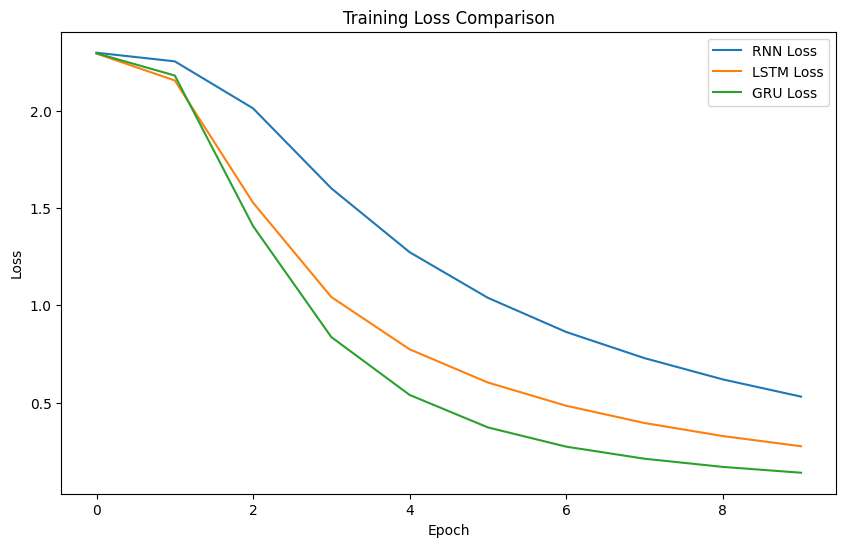

In [7]:
main(models, train_loader, test_loader, **params)

In [8]:
model_configs = {
    "RNN": "RNN.pth",
    "LSTM": "LSTM.pth",
    "GRU": "GRU.pth"
}

for model_type, model_path in model_configs.items():
    print(f"\nTesting {model_type}...")
    test_model(model_type, model_path, test_loader, device, params["hidden_size"])


Testing RNN...
RNN Test Accuracy: 0.9565

Sample Input: [5. 6. 8. 8. 0. 3. 6. 2. 9. 5.]
Predicted Output: [5 1 3 3 5 8 1 7 4 0]
True Output: [5 1 3 3 5 8 1 7 4 0]

Testing LSTM...
LSTM Test Accuracy: 0.9895

Sample Input: [5. 6. 8. 8. 0. 3. 6. 2. 9. 5.]
Predicted Output: [5 1 3 3 5 8 1 7 4 0]
True Output: [5 1 3 3 5 8 1 7 4 0]

Testing GRU...
GRU Test Accuracy: 0.9942

Sample Input: [5. 6. 8. 8. 0. 3. 6. 2. 9. 5.]
Predicted Output: [5 1 3 3 5 8 1 7 4 0]
True Output: [5 1 3 3 5 8 1 7 4 0]
